<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/w8/tutorials/W8_AutoEncoders_GANs/W8_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 8 Part 2
# wrapping up VAE, and doing GANs

__Instructor__: Konrad Kording

__Content creators:__ Arash Ash, Richard Lange

---
# Tutorial Objectives

In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)

my_pennkey = 'value' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


In [2]:
# @title Slides
# from IPython.display import HTML
# HTML('<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vSPvHqDTmMq4GyQy6lieNEFxq4qz1SmqC2RNoeei3_niECH53zneh8jJVYOnBIdk0Uaz7y2b9DK8V1t/embed?start=false&loop=false&delayms=3000" frameborder="0" width="480" height="299" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')

---
# Setup

In [3]:
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import random
import pathlib
import random, time
from tqdm.notebook import tqdm, trange

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# @title Seeding for reproducibility
seed = 522
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
# @title Downloads
%%capture
!rm -r AnimalFaces32x32/
!git clone https://github.com/arashash/AnimalFaces32x32
!rm -r afhq/
!unzip ./AnimalFaces32x32/afhq_32x32.zip 

In [16]:
# @title Animal Faces Dataset

H = 32
W = 32
C = 3
num_classes = 3

my_dataset_size = (C, H, W)
my_dataset_dim = C*H*W

def get_data_loaders(batch_size):
  # define the transform done only during training
  augmentation_transforms = [transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                                    saturation=0.1, hue=0.0),
                             transforms.RandomHorizontalFlip()]

  # define the transform done in training and testing (after augmentation)
  preprocessing_transforms = [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  
  # compose them together
  train_transform = transforms.Compose(augmentation_transforms + preprocessing_transforms)
  test_transform = transforms.Compose(preprocessing_transforms)

  # using pathlib to be compatible with all OS's
  data_path = pathlib.Path('.')/'afhq'

  # define the dataset objects (they can load one by one)
  img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)
  img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

  # define the dataloader objects (they can load batch by batch)
  img_train_loader = DataLoader(img_train_dataset, batch_size=batch_size, pin_memory=True,
                                shuffle=True, num_workers=0, drop_last=True)
  # num_workers can be set to higher if running on Colab Pro TPUs to speed up,
  # with more than one worker, it will do multithreading to queue batches
  img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=0)
  
  return img_train_loader, img_test_loader

In [17]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

In [18]:
# @title Helper functions
def imshow(img):
    img -= torch.min(img)
    img *= 255/torch.max(img)
    npimg = img.numpy().astype(np.uint8)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

def progress(batch, loss, batches):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{batch}'
            max='{batches}',
            style='width: 100%'
        >
            {batch}
        </progress>
    """.format(loss=loss, batch=batch, batches=batches))

In [35]:
# @title Copy of rsample, log_p_x, kl_q_p, BiasLayer, and ConvVAE from T1

def rsample(phi, n_samples):
    """Sample z ~ q(z;phi)
    Ouput z is size [b,n_samples,K] given phi with shape [b,K+1]. The first K
    entries of each row of phi are the mean of q, and phi[:,-1] is the log
    standard deviation
    """
    b, kplus1 = phi.size()
    eps = torch.randn(b, n_samples, kplus1-1, device=phi.device)
    mu, sig = phi[:, :-1], phi[:,-1].exp()
    return eps*sig.view(b,1,1) + mu.view(b,1,kplus1-1)

def log_p_x(x, mu_xs, sig_x):
    """Given [batch, ...] input x and [batch, n, ...] reconstructions, compute
    pixel-wise log Gaussian probability

    Sum over pixel dimensions, but mean over batch and samples.
    """
    b, n = mu_xs.size()[:2]
    # Flatten out pixels and add a singleton dimension [1] so that x will be
    # implicitly expanded when combined with mu_xs
    x = x.reshape(b, 1, -1)
    _, _, p = x.size()
    squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

    # Size of squared_error is [b,n,p]. log prob is by definition sum over [p].
    # Expected value requires mean over [n]. Handling different size batches
    # requires mean over [b].
    return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))

def kl_q_p(zs, phi):
    """Given [b,n,k] samples of z drawn from q, compute estimate of KL(q||p).
    phi must be size [b,k+1]
    """
    b, n, k = zs.size()
    mu_p = torch.zeros((k,), device=phi.device)
    sig_p = torch.ones((k,), device=phi.device)
    mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
    log_p = -0.5*(zs - mu_p.view(1,1,k))**2 / sig_p.view(1,1,k)**2 - torch.log(sig_p.view(1,1,k))
    log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
    # Size of log_q and log_p is [b,n,k]. Sum along [k] but mean along [b,n]
    return (log_q - log_p).sum(dim=2).mean(dim=(0,1))

class BiasLayer(nn.Module):
    def __init__(self, shape):
        super(BiasLayer, self).__init__()
        init_bias = torch.zeros(shape)
        self.bias = nn.Parameter(init_bias, requires_grad=True)
    
    def forward(self, x):
        return x + self.bias

class ConvVAE(nn.Module):
    def __init__(self, K, num_filters=32, filter_size=5):
        super(ConvVAE, self).__init__()
        
        # With padding=0, the number of pixels cut off from each image dimension
        # is filter_size // 2. Double it to get the amount of pixels lost in
        # width and height per Conv2D layer, or added back in per 
        # ConvTranspose2D layer.
        filter_reduction = 2 * (filter_size // 2)

        # After passing input through two Conv2d layers, the shape will be
        # 'shape_after_conv'. This is also the shape that will go into the first
        # deconvolution layer in the decoder
        self.shape_after_conv = (num_filters,
                                 my_dataset_size[1]-2*filter_reduction,
                                 my_dataset_size[2]-2*filter_reduction)
        flat_size_after_conv = self.shape_after_conv[0] \
            * self.shape_after_conv[1] \
            * self.shape_after_conv[2]

        # Define the recognition model (encoder or q) part
        self.q_bias = BiasLayer(my_dataset_size)      
        self.q_conv_1 = nn.Conv2d(my_dataset_size[0], num_filters, 5)
        self.q_conv_2 = nn.Conv2d(num_filters, num_filters, 5)
        self.q_fc_phi = nn.Linear(flat_size_after_conv, K+1)

        # Define the generative model (decoder or p) part
        self.p_fc_upsample = nn.Linear(K, flat_size_after_conv)
        self.p_deconv_1 = nn.ConvTranspose2d(num_filters, num_filters, 5)
        self.p_deconv_2 = nn.ConvTranspose2d(num_filters, my_dataset_size[0], 5)
        self.p_bias = BiasLayer(my_dataset_size)

        # Define a special extra parameter to learn scalar sig_x for all pixels
        self.log_sig_x = nn.Parameter(torch.zeros(()))
    
    def infer(self, x):
        """Map (batch of) x to (batch of) phi which can then be passed to
        rsample to get z
        """
        s = self.q_bias(x)
        s = F.relu(self.q_conv_1(s))
        s = F.relu(self.q_conv_2(s))
        flat_s = s.view(s.size()[0], -1)
        phi = self.q_fc_phi(flat_s)
        return phi

    def generate(self, zs):
        """Map [b,n,k] sized samples of z to [b,n,p] sized images
        """
        # Note that for the purposes of passing through the generator, we need
        # to reshape zs to be size [b*n,k]
        b, n, k = zs.size()
        s = zs.view(b*n, -1)
        s = F.relu(self.p_fc_upsample(s)).view((b*n,) + self.shape_after_conv)
        s = F.relu(self.p_deconv_1(s))
        s = self.p_deconv_2(s)
        s = self.p_bias(s)
        mu_xs = s.view(b, n, -1)
        return mu_xs
    
    def forward(self, x):
        # VAE.forward() is not used for training, but we'll treat it like a
        # classic autoencoder by taking a single sample of z ~ q
        phi = self.infer(x)
        zs = rsample(phi, 1)
        return self.generate(zs).view(x.size())

    def elbo(self, x, n=1):
        # Compute ELBO for a batch of inputs
        phi = self.infer(x)
        zs = rsample(phi, n)
        mu_xs = self.generate(zs)
        return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)

def train_vae(vae, dataset, epochs=10, n_samples=16):
    opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-6)
    elbo_vals = []
    vae.to(device)
    vae.train()
    loader = DataLoader(dataset, batch_size=100, shuffle=True, pin_memory=True)
    for epoch in trange(epochs, desc='Epochs'):
        for im, _ in tqdm(loader, total=len(dataset)//100, desc='Batches', leave=False):
            im = im.to(device)
            opt.zero_grad()
            loss = -vae.elbo(im)
            loss.backward()
            opt.step()

            elbo_vals.append(-loss.item())
    vae.to('cpu')
    vae.eval()
    return elbo_vals

---
# Section 1: wrapping up VAE

In [36]:
#@title Video : 
try: t1;
except NameError: t1=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="L6AmjfozoBc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

# video


Video available at https://youtube.com/watch?v=L6AmjfozoBc


## Exercise 1.1: why vanilla VAEs fail?

Now that we have a pretty good idea about Auto-encoders, let's see what they fail?. When the data distribution becomes more complicated, they often struggle to generate realistic examples. Let's use the Animal Faces dataset to see whether we can use them to create cute cat faces?

let's first remember Animal Faces dataset:

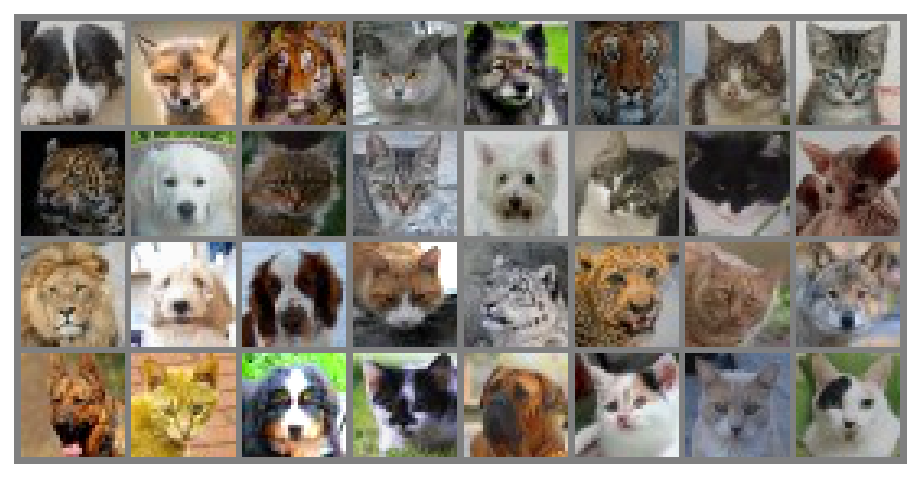

In [37]:
batch_size = 32
img_train_loader, img_test_loader = get_data_loaders(batch_size)

# get some random training images
dataiter = iter(img_train_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images, nrow=8))

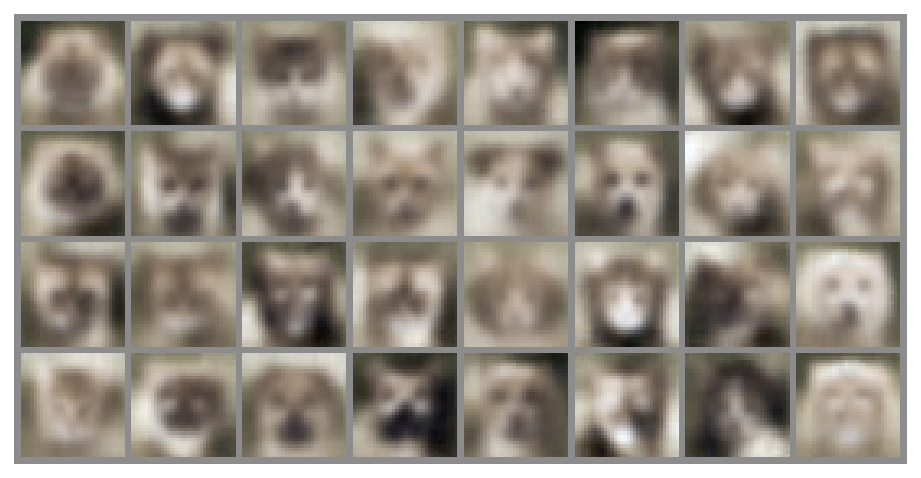

In [38]:
def train_vae(vae, loader, epochs=5, n_samples=1):
    opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-5)
    
    max_steps = epochs*len(loader)
    progress_bar = display(progress(0, 0, max_steps), display_id=True)

    elbo_vals = []
    vae.to(device)
    vae.train()
    steps = 0
    for epoch in range(epochs):
        for im, _ in loader:
            opt.zero_grad()
            loss = -vae.elbo(im.to(device), n_samples)
            loss.backward()
            opt.step()

            elbo_vals.append(-loss.item())
            progress_bar.update(progress(steps, loss.item(), max_steps))
            steps += 1

    vae.to('cpu')
    vae.eval()
    return elbo_vals

K = 15
vae = ConvVAE(K=K)

# training
elbo_vals = train_vae(vae, img_train_loader, n_samples=10)

# is standard normal distribution a good choice for sampling the latent space?
zs = torch.randn(batch_size, 1, K)
images = vae.generate(zs).detach().view(batch_size, C, H, W)
imshow(make_grid(images, nrow=8))

In [ ]:
#@markdown Why do you think the generated images don't have realistic distributions (e.g, not even colored!)?
w8_why_different_distribution = '' #@param {type:"string"}

---
# Section 2: Generative adversarial networks (GANs)

Generative models can be easy to test; if you can't show it, you haven't learned it! And this is the basic idea of GANs. The objective is to create real examples of the data.

In [ ]:
# @title Mode Collapse!
from IPython.display import HTML
HTML('<iframe width="1500" height="660" src="https://poloclub.github.io/ganlab/" allowfullscreen></iframe>')

In [ ]:
#@title Video : 
try: t2;
except NameError: t2=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="L6AmjfozoBc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

# video


Video available at https://youtube.com/watch?v=L6AmjfozoBc


## Exercise 2.1: Train a simple GAN using two MLPs
 
Let's first review the code from Week 3:


In [ ]:
# to_remove solution

class MLP(nn.Module):
    def __init__(self, actv, input_units, hidden_units_list, output_units,
                 out_actv=None):
        super(MLP, self).__init__()

        # Initialize layers of MLP
        self.layers = nn.ModuleList()

        # Loop over layers and create each one
        in_units = input_units
        for units in hidden_units_list:
          out_units = units

          self.layers += [nn.Linear(in_units, out_units)]
          in_units = out_units  

          exec('self.activation = nn.%s'%actv)  
          self.layers += [self.activation]


        # Create final layer
        self.out = nn.Linear(in_units, output_units)

        self.out_actv = out_actv
        if out_actv:
          exec('self.out_actv = nn.%s'%out_actv) 

    def forward(self, x):

        # Flatten inputs to 2D (if more than that)
        x = x.view(x.shape[0], -1)  

        # Get activations of each layer
        for layer in self.layers:
          x = layer(x)

        # Get outputs
        x = self.out(x) 
        
        if self.out_actv:
          x = self.out_actv(x)

        return x

Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves. Since the generator is needed when calculating the discriminator's loss, you will need to call `.detach()` on the generator result to ensure that only the discriminator is updated!

Remember that you have already defined a loss function earlier (`criterion`) and you are encouraged to use `torch.ones_like` and `torch.zeros_like` instead of `torch.ones` or `torch.zeros`. If you use `torch.ones` or `torch.zeros`, you'll need to pass `device=device` to them.

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    #### END CODE HERE ####
    return disc_loss

In [ ]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

Adam reminder: 

* $g_{t} \leftarrow \nabla_{\theta} f_{t}\left(\theta_{t-1}\right)$ (Get gradients w.r.t. stochastic objective at timestep $\left.t\right)$ 

* $m_{t} \leftarrow \beta_{1} \cdot m_{t-1}+\left(1-\beta_{1}\right) \cdot g_{t}$ (Update biased first moment estimate) 

* $v_{t} \leftarrow \beta_{2} \cdot v_{t-1}+\left(1-\beta_{2}\right) \cdot g_{t}^{2}$ (Update biased second raw moment estimate) 

* $\widehat{m}_{t} \leftarrow m_{t} /\left(1-\beta_{1}^{t}\right)$ (Compute bias-corrected first moment estimate) 

* $\widehat{v}_{t} \leftarrow v_{t} /\left(1-\beta_{2}^{t}\right)$ (Compute bias-corrected second raw moment estimate) 

* $\theta_{t} \leftarrow \theta_{t-1}-\alpha \cdot \widehat{m}_{t} /\left(\sqrt{\widehat{v}_{t}}+\epsilon\right)$ (Update parameters)

In [ ]:
 def train_simple_GAN(gen, disc,
                      loader, z_dim, 
                      epochs=5, disp_batch_size = 24):
    gen.to(device).train()
    disc.to(device).train()

    criterion = nn.BCELoss()
    # criterion = nn.MSELoss()
    disc_opt = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.0, 0.999))
    gen_opt = optim.Adam(gen.parameters(), lr=3e-4, betas=(0.0, 0.999))

    fix_noise = get_noise(disp_batch_size, z_dim, device=device)

    max_steps = epochs*len(loader)
    progress_bar = display(progress(0, 0, max_steps), display_id=True)
    gen_losses = []
    disc_losses = []
    steps = 0
    for epoch in range(epochs):
        for i, (real, _) in enumerate(loader):
          real = real.to(device)
          batch_size = len(real)

          ### Update discriminator ###
          # Zero out the gradients before backpropagation
          disc_opt.zero_grad()

          # Calculate discriminator loss
          disc_loss = get_disc_loss(gen, disc, criterion, real, batch_size, z_dim, device)

          # Update gradients
          disc_loss.backward(retain_graph=True)

          # Update optimizer
          disc_opt.step()

          ### Update generator ###
          #     Hint: This code will look a lot like the discriminator updates!
          #     These are the steps you will need to complete:
          #       1) Zero out the gradients.
          #       2) Calculate the generator loss, assigning it to gen_loss.
          #       3) Backprop through the generator: update the gradients and optimizer.
          gen_opt.zero_grad()
          gen_loss = get_gen_loss(gen, disc, criterion, batch_size, z_dim, device)
          gen_loss.backward()
          gen_opt.step()

          # update the loss trackers
          gen_losses.append(gen_loss.item())
          disc_losses.append(disc_loss.item())

          progress_bar.update(progress(steps, (gen_losses[-1], disc_losses[-1]), max_steps))
          steps += 1


        images = gen(fix_noise).detach().cpu().view(disp_batch_size, C, H, W)
        imshow(make_grid(images, nrow=8))
    
    gen.to('cpu').eval()
    disc.to('cpu').eval()

    plt.plot(gen_losses, label='Generator loss')
    plt.plot(disc_losses, label='Discriminator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

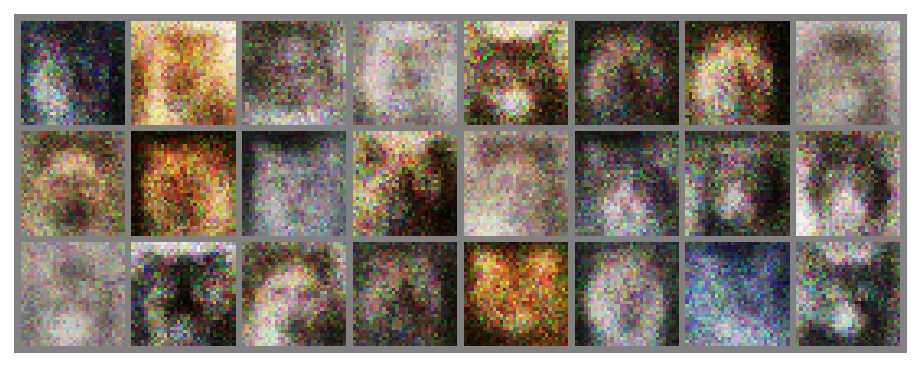

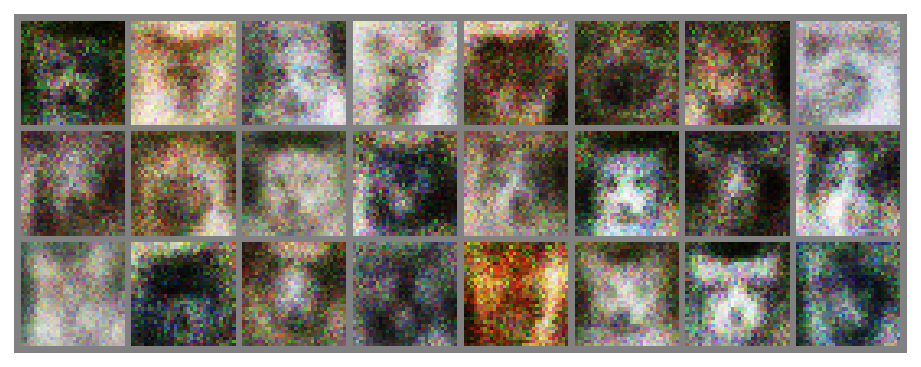

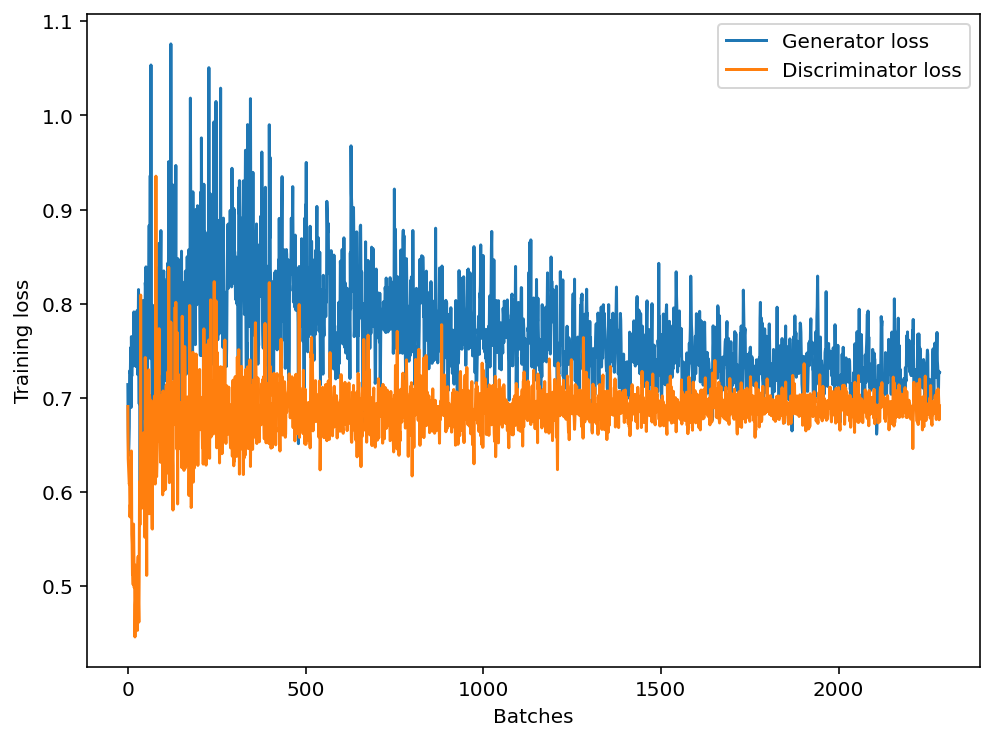

In [ ]:
z_dim = 64

actv = 'PReLU()'

disc = MLP(actv=actv,
          input_units = 3*32*32,
          hidden_units_list = [1024, 1024],
          output_units = 1,
          out_actv = 'Sigmoid()')

gen = MLP(actv=actv,
          input_units = z_dim,
          hidden_units_list = [1024, 1024],
          output_units = 3*32*32,
          out_actv = 'Tanh()')

batch_size = 32
img_train_loader, img_test_loader = get_data_loaders(batch_size)
train_simple_GAN(gen, disc, img_train_loader, z_dim)

# Deep Convolutional GANs

https://arxiv.org/abs/1511.06434

Architecture guidelines for stable Deep Convolutional GANs
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.


In [ ]:
# to_remove solution

class ConvNet(nn.Module):
    def __init__(self, actv, input_channel, hidden_channels, out_actv=None, is_gen=False):
        super(ConvNet, self).__init__()
        self.is_gen = is_gen

        # Initialize layers of MLP
        self.layers = nn.ModuleList()

        # Loop over layers and create each one
        in_channels = input_channel
        for i in range(len(hidden_channels)):
          out_channels = hidden_channels[i] 

          if self.is_gen:  
            self.layers += [nn.ConvTranspose2d(
                                in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=4,
                                stride=2,
                                padding=1
                            )]
          else:
            self.layers += [nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1
                )]

          in_channels = out_channels
          exec('self.activation = nn.%s'%actv)
          self.layers += [
            self.activation]  

        # Create final layer
        if self.is_gen:  
          self.out = nn.ConvTranspose2d(
                                in_channels=out_channels,
                                out_channels=3,
                                kernel_size=4,
                                stride=2,
                                padding=1,
                            )
        else:
          self.out = nn.Conv2d(
                      in_channels=out_channels,
                      out_channels=1,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                  )
        
        self.out_actv = out_actv
        if out_actv:
          exec('self.out_actv = nn.%s'%out_actv) 

    def forward(self, x):
        if self.is_gen: 
          # make inputs to 1x1 2D with channel noise
          x = x.view(x.shape[0], -1, 1, 1)
        else:
          x = x.view(x.shape[0], -1, H, W)

        # Get activations of each layer
        for layer in self.layers:
          x = layer(x)

        # Get outputs
        x = self.out(x)

        if self.out_actv:
          x = self.out_actv(x)
        return x

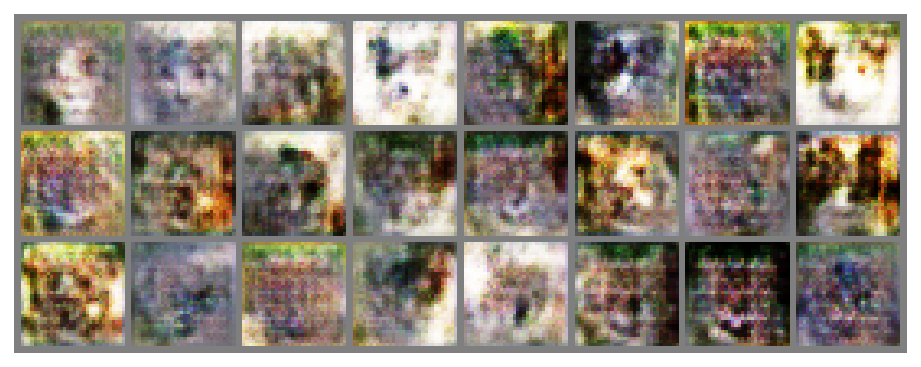

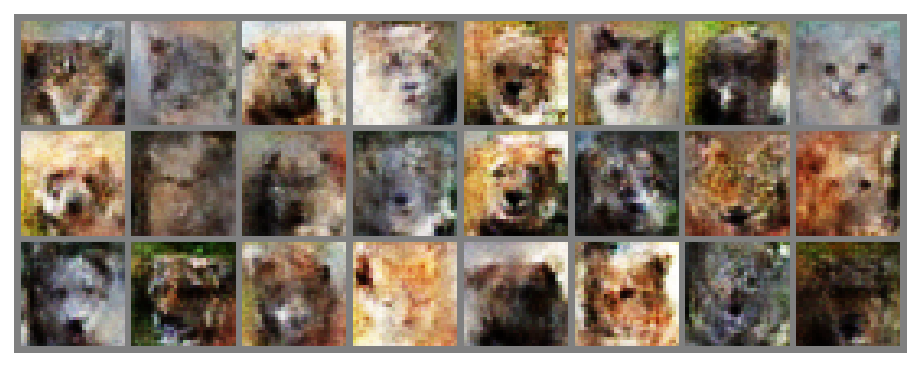

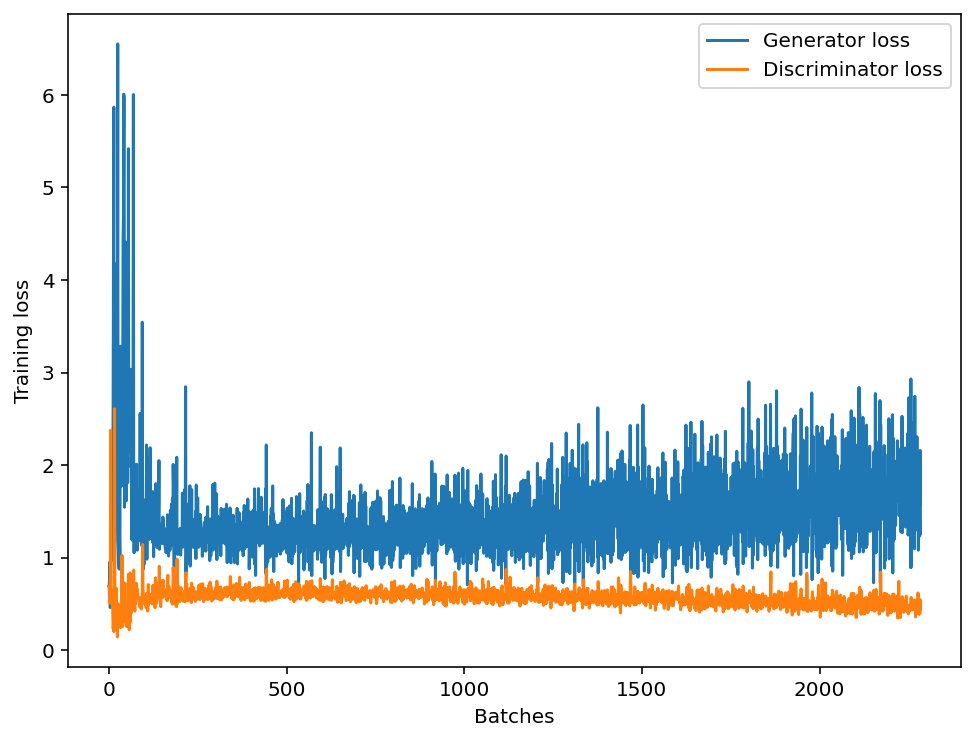

In [ ]:
z_dim = 64

actv = 'PReLU()'

disc = ConvNet(actv=actv,
          input_channel = 3,
          hidden_channels = [128, 256, 512, 1024], 
          out_actv = 'Sigmoid()', is_gen=False)

gen = ConvNet(actv=actv,
          input_channel = z_dim,
          hidden_channels = [1024, 512, 256, 128], 
          out_actv = 'Tanh()', is_gen=True)

batch_size = 32
img_train_loader, img_test_loader = get_data_loaders(batch_size)
train_simple_GAN(gen, disc, img_train_loader, z_dim)

Why not more diverse images?! 

Mode collapse

# Conditional GANs

In [ ]:
 def train_Conditional_WGAN(gen, opt_gen, disc, opt_disc, loader, z_dim,
                            epochs=10,
                            WEIGHT_CLIP=0.01):
    gen.to(device).train()
    disc.to(device).train()

    fix_z_size = 24
    fix_zs = torch.randn(fix_z_size, z_dim).to(device).float()
    class_zs = torch.zeros(fix_z_size, num_classes).to(device).float()
    class_zs[:8, 0] = 1 # one hot vector of first class
    class_zs[8:16, 1] = 1 # of second class
    class_zs[16:, 2] = 1 # of third class
    fix_zs = torch.cat([fix_zs, class_zs], axis=1)

    progress_bar = display(progress(0, 0, epochs), display_id=True)
    gen_losses = []
    disc_losses = []
    for epoch in trange(epochs, desc='Epochs'):
        for i, (real, labels) in enumerate(tqdm(loader, total=len(loader), desc='Batches', leave=False)):
          
          real = real.to(device)
          batch_size = real.shape[0]
          onehot_z_target = torch.diag(torch.ones(num_classes))[labels].to(device)
          onehot_channel_target = F.interpolate(onehot_z_target.view(batch_size, -1, 1, 1), (H, W))
          real = torch.cat([real, onehot_channel_target], axis=1)

          ### Train Generator:
          noise = torch.randn(batch_size, z_dim).to(device)
          noise = torch.cat([noise, onehot_z_target], axis=1)

          fake = torch.tanh(gen(noise))
          fake = torch.cat([fake, onehot_channel_target], axis=1)

          disc_real = disc(fake)
          lossG = -torch.mean(disc_real)
          opt_gen.zero_grad()
          lossG.backward()
          opt_gen.step()

          ### Train Discriminator:
          noise = torch.randn(batch_size, z_dim).to(device)
          noise = torch.cat([noise, onehot_z_target], axis=1)
          
          fake = torch.tanh(gen(noise))
          fake = torch.cat([fake, onehot_channel_target], axis=1)
          # we can call detach on fake since we don't need to backprop to gen
          disc_fake = disc(fake.detach())
          disc_real = disc(real)
          lossD = -(torch.mean(disc_real) - torch.mean(disc_fake))
          opt_disc.zero_grad()
          lossD.backward()
          opt_disc.step()

          # clip disc weights between -0.01, 0.01
          # see this for a better solution: https://arxiv.org/abs/1704.00028
          for p in disc.parameters():
              p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

          progress_bar.update(progress(epoch+1, (lossG.item(), lossD.item()), epochs))
          gen_losses.append(lossG.item())
          disc_losses.append(lossD.item())

        if epoch % 5 == 0  or epoch == epochs-1:
          gen.eval()
          images = torch.tanh(gen(fix_zs)).detach().cpu().view(fix_z_size, C, H, W)
          imshow(make_grid(images, nrow=8))
          gen.train()
    
    gen.to('cpu').eval()
    disc.to('cpu').eval()

    plt.plot(gen_losses, label='Generator loss')
    plt.plot(disc_losses, label='Discriminator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

disc = ConvNet(actv=actv,
          input_channel = 3 + num_classes,
          hidden_channels = [128, 256, 512, 1024], 
          out_actv = 'Sigmoid()', is_gen=False)

gen = ConvNet(actv=actv,
          input_channel = z_dim + num_classes,
          hidden_channels = [1024, 512, 256, 128], 
          out_actv = 'Tanh()', is_gen=True)

opt_conv_disc = optim.Adam(disc.parameters(), lr=3e-4, betas=(0, 0.9))
opt_conv_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0, 0.9))

batch_size = 32
img_train_loader, img_test_loader = get_data_loaders(batch_size)
# train_Conditional_WGAN(gen, opt_conv_gen,
#                       disc, opt_conv_disc,
#                       img_train_loader, z_dim, epochs=10)

# Cycle GANs
So far we have been able to only generate example of a distribution. but what if we want to learn a particular mapping and do translation from one domain to another! We can not acheive this with single GAN. so if one GAN is not enough, two should do the trick!

Let's see how two GANs can learn unsupervised unpaired translation.

Let's unscramble Week3 images by training a CycleGAN

Let's introduce AB notations for any unpaired unsupervised translation and relate it to our task: 

A: source, scrambled images  
B: target, original images

And here are the generetators:

$$
G_{AB}(A) \longrightarrow B \\

G_{BA}(B) \longrightarrow A
$$

And here are the discriminators:

$$
D_{A}(A) \longrightarrow \mathbf{P}(\text{$A$ is real}) \\

D_{B}(B) \longrightarrow \mathbf{P}(\text{$B$ is real})
$$

So let's get started by first creeating the B dataloader which returnes scrambled images.

In [ ]:
def get_scrambled_data_loaders(batch_size, rand_perm):
  class Scrambler():
    def __call__(self, tensor):
        tensor_shape = tensor.shape
        tensor_flat = tensor.view(-1)
        tensor_scrambled = tensor_flat[rand_perm]
        return tensor_scrambled.view(tensor_shape)

  # define the transform done only during training
  augmentation_transforms = [transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                                    saturation=0.1, hue=0.0),
                             transforms.RandomHorizontalFlip()]

  # define the transform done in training and testing (after augmentation)
  preprocessing_transforms = [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  
  # compose them together
  train_transform = transforms.Compose(augmentation_transforms + preprocessing_transforms + [Scrambler()])
  test_transform = transforms.Compose(preprocessing_transforms + [Scrambler()])

  # using pathlib to be compatible with all OS's
  data_path = pathlib.Path('.')/'afhq'

  # define the dataset objects (they can load one by one)
  img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)
  img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

  # define the dataloader objects (they can load batch by batch)
  img_train_loader = DataLoader(img_train_dataset, batch_size=batch_size, pin_memory=True,
                                shuffle=True, num_workers=0, drop_last=True)
  # num_workers can be set to higher if running on Colab Pro TPUs to speed up,
  # with more than one worker, it will do multithreading to queue batches
  img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=0)
  
  return img_train_loader, img_test_loader

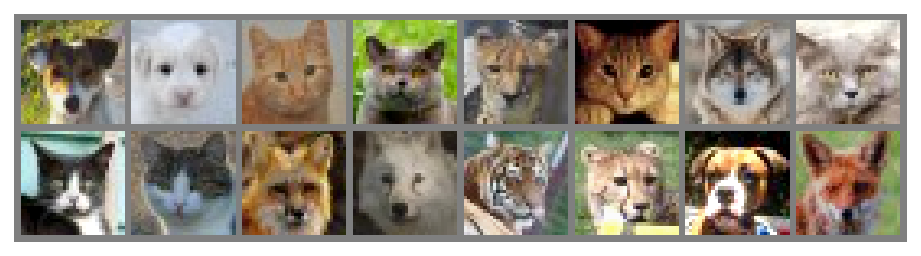

In [ ]:
batch_size = 16
rand_perm = torch.randperm(3*32*32)
reverse_rand_perm = torch.argsort(rand_perm)
scrambled_img_train_loader, _ = get_scrambled_data_loaders(batch_size, rand_perm)
img_train_loader, img_test_loader = get_data_loaders(batch_size)

# get some random scrambled training images
dataiter = iter(scrambled_img_train_loader)
images, labels = dataiter.next()

# checking whether we can reverse it images
imshow(make_grid(images, nrow=8))
images_flat = images.view(batch_size, -1)
unscrambled_images = images_flat[:, reverse_rand_perm].view(images.shape)
imshow(make_grid(unscrambled_images, nrow=8))

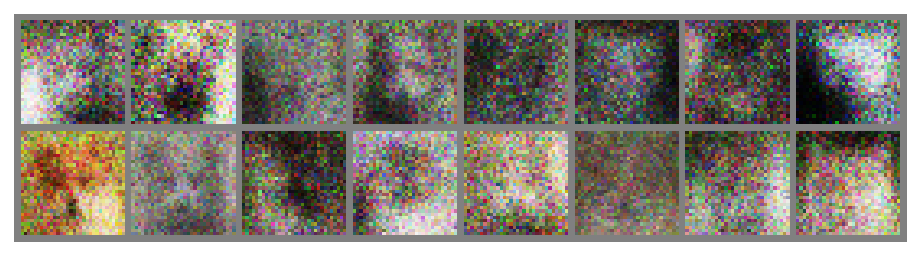

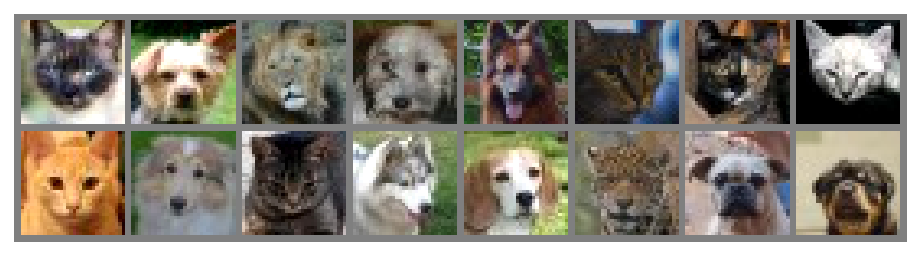

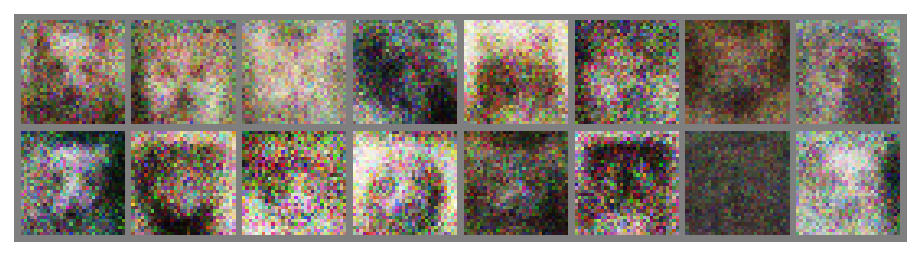

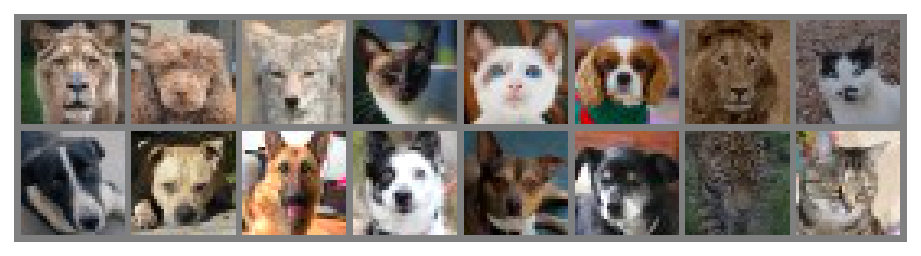

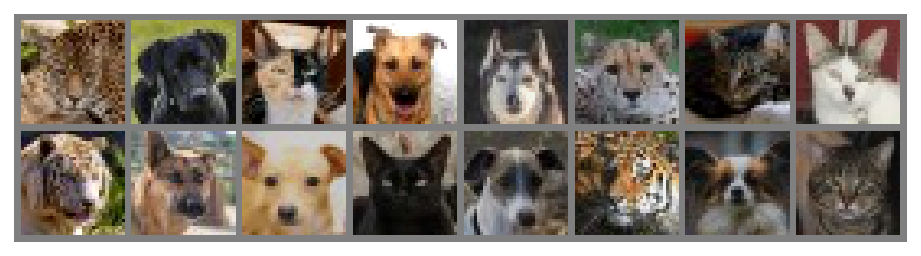

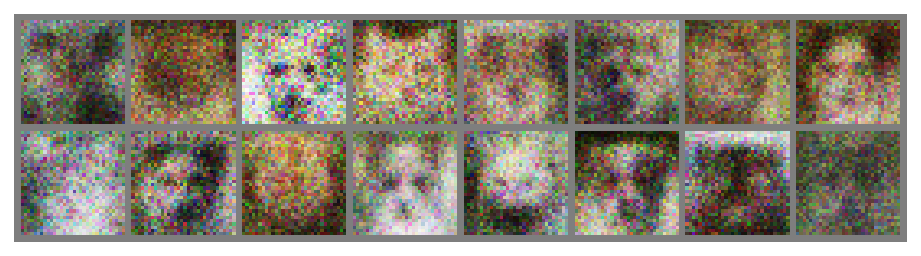

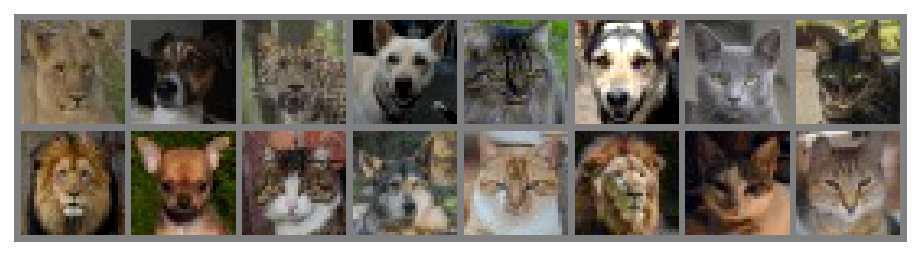

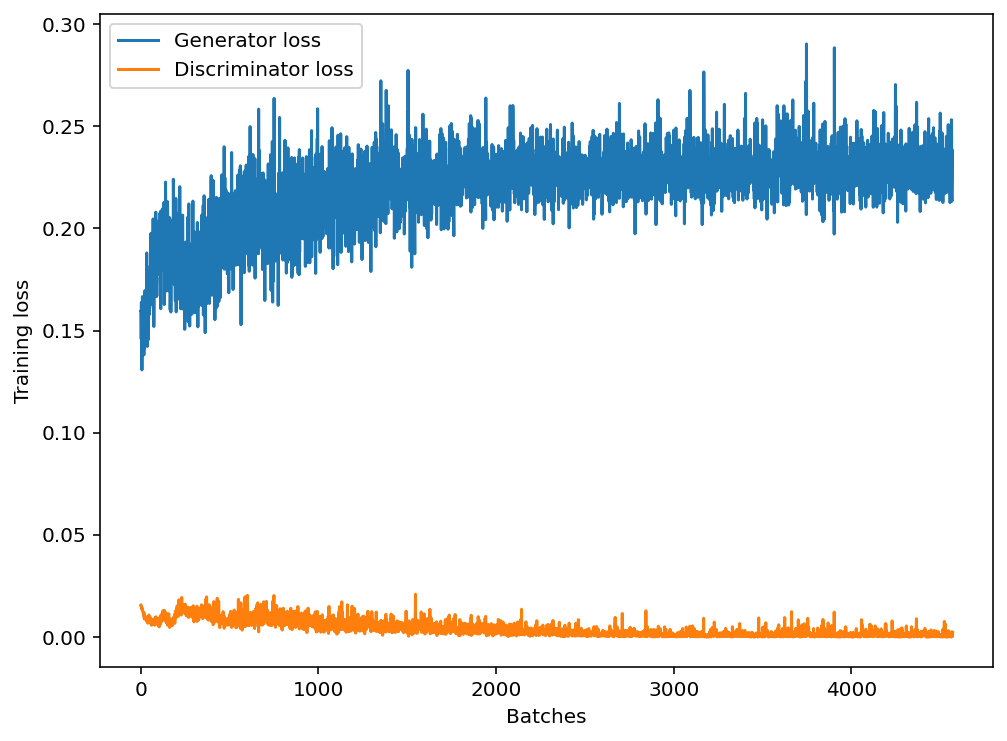

In [ ]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    disc_fake_X_hat = disc_X(fake_X.detach()) # Detach generator
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))
    disc_real_X_hat = disc_X(real_X)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2
    return disc_loss

def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    fake_Y = gen_XY(real_X)
    disc_fake_Y_hat = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
    return adversarial_loss, fake_Y

def get_identity_loss(real_X, gen_YX, identity_criterion):
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)
    return identity_loss, identity_X

def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X)
    return cycle_loss, cycle_X

def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion,
                 cycle_criterion, lambda_identity=1, lambda_cycle=10):

    # Hint 1: Make sure you include both directions - you can think of the generators as collaborating
    # Hint 2: Don't forget to use the lambdas for the identity loss and cycle loss!
    # Adversarial Loss -- get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion)
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB

    # Identity Loss -- get_identity_loss(real_X, gen_YX, identity_criterion)
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B

    # Cycle-consistency Loss -- get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion)
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB

    # Total loss
    gen_loss = lambda_identity * gen_identity_loss + lambda_cycle * gen_cycle_loss + gen_adversarial_loss
    # gen_loss = lambda_cycle * gen_cycle_loss + gen_adversarial_loss
    return gen_loss, fake_A, fake_B 
 
def train_unscrambler_GAN(gen_AB, gen_BA, gen_opt,
                           disc_A, disc_B, disc_A_opt, disc_B_opt,
                           loader_A, loader_B, epochs=5):
    gen.to(device).train()
    disc.to(device).train()

    adv_criterion = nn.MSELoss() 
    recon_criterion = nn.L1Loss()

    gen_losses = []
    disc_losses = []
    progress_bar = display(progress(0, 0, epochs), display_id=True)
    for epoch in trange(epochs, desc='Epochs'):
        for i, ((real_A, _), (real_B, _)) in enumerate(tqdm(zip(loader_A, loader_B),
                                                            total=len(loader_A), desc='Batches',
                                                            leave=False)):
          real_A_shape = real_A.shape
          batch_size = real_A_shape[0]
          real_A = real_A.to(device).view(batch_size, -1)
          real_B = real_B.to(device).view(batch_size, -1)

          ### Update discriminator A ###
          disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
          with torch.no_grad():
              fake_A = gen_BA(real_B)
          disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
          disc_A_loss.backward(retain_graph=True) # Update gradients
          disc_A_opt.step() # Update optimizer

          ### Update discriminator B ###
          disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
          with torch.no_grad():
              fake_B = gen_AB(real_A)
          disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
          disc_B_loss.backward(retain_graph=True) # Update gradients
          disc_B_opt.step() # Update optimizer

          ### Update generator ###
          gen_opt.zero_grad()
          gen_loss, _, _ = get_gen_loss(
              real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
          )
          # gen_loss += (torch.mean((gen_BA.out.weight != 0).float()) + torch.mean((gen_AB.out.weight != 0).float()))/2
          gen_loss.backward() # Update gradients
          gen_opt.step() # Update optimizer

          # Keep track of the average discriminator loss
          mean_discriminator_loss = disc_A_loss.item() / batch_size
          disc_losses += [mean_discriminator_loss]

          # Keep track of the average generator loss
          mean_generator_loss = gen_loss.item() / batch_size
          gen_losses += [mean_generator_loss]

          progress_bar.update(progress(epoch+1, (mean_generator_loss,
                                                 mean_discriminator_loss), epochs))
          
        imshow(make_grid(fake_B.view(real_A_shape).detach().cpu(), nrow=8))

        real_A_flat = real_A.view(batch_size, -1).detach().cpu()
        real_A_unscambled = real_A_flat[:, reverse_rand_perm].view(real_A_shape)
        imshow(make_grid(real_A_unscambled, nrow=8))
    
    gen.to('cpu').eval()
    disc.to('cpu').eval()

    plt.plot(gen_losses, label='Generator loss')
    plt.plot(disc_losses, label='Discriminator loss')
    plt.xlabel('Batches')
    plt.ylabel('Training loss')
    plt.legend()
    plt.show()

actv = 'PReLU()'

disc_A = MLP(actv=actv,
          input_units = 3*32*32,
          hidden_units_list = [256, 256],
          output_units = 1,
          out_actv = 'Sigmoid()').to(device)

disc_B = MLP(actv=actv,
          input_units = 3*32*32,
          hidden_units_list = [256, 256],
          output_units = 1,
          out_actv = 'Sigmoid()').to(device)

gen_AB = MLP(actv=actv,
          input_units = 3*32*32,
          hidden_units_list = [],
          output_units = 3*32*32,
          out_actv = 'Tanh()').to(device)
gen_AB.out.weight.data = torch.diag(torch.ones(3*32*32)).to(device)
gen_AB.out.bias.data = torch.zeros(3*32*32).to(device)

gen_BA = MLP(actv=actv,
          input_units = 3*32*32,
          hidden_units_list = [],
          output_units = 3*32*32,
          out_actv = 'Tanh()').to(device)
gen_BA.out.weight.data = torch.diag(torch.ones(3*32*32)).to(device)
gen_BA.out.bias.data = torch.zeros(3*32*32).to(device)

gen_parameters = list(gen_AB.parameters())+list(gen_BA.parameters())
gen_opt = optim.Adam(gen_parameters, lr=1e-4, betas=(0.0, 0.999))
disc_A_opt = optim.Adam(disc_A.parameters(), lr=1e-4, betas=(0.0, 0.999))
disc_B_opt = optim.Adam(disc_B.parameters(), lr=1e-4, betas=(0.0, 0.999))

train_unscrambler_GAN(gen_AB, gen_BA, gen_opt,
                      disc_A, disc_B, disc_A_opt, disc_B_opt,
                      scrambled_img_train_loader, img_train_loader,
                      epochs=5)

# Controllable GANs

In [ ]:
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [ ]:
gen = model.netG.eval().to(device)

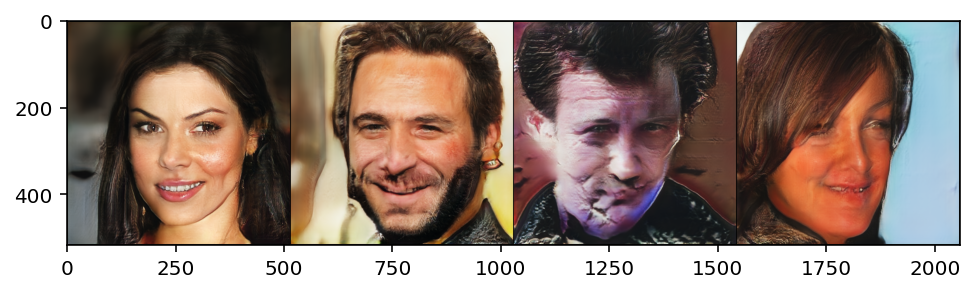

In [ ]:
num_images = 4
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    # generated_images = model.test(noise)
    generated_images = torch.tanh(gen(noise))

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
# plt.show()

In [ ]:
class Classifier(nn.Module):
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

In [ ]:
!git clone https://github.com/frankwwu/Coursera-Generative-Adversarial-Networks-GANs-Specialization
%cd /content/Coursera-Generative-Adversarial-Networks-GANs-Specialization/1. Build Basic Generative Adversarial Networks (GANs)/Week 4. Conditional GAN & Controllable Generation/

fatal: destination path 'Coursera-Generative-Adversarial-Networks-GANs-Specialization' already exists and is not an empty directory.
/content/Coursera-Generative-Adversarial-Networks-GANs-Specialization/1. Build Basic Generative Adversarial Networks (GANs)/Week 4. Conditional GAN & Controllable Generation


In [ ]:
n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


In [ ]:
def calculate_updated_noise(noise, weight):
    new_noise = noise + ( noise.grad * weight)
    return new_noise

In [ ]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

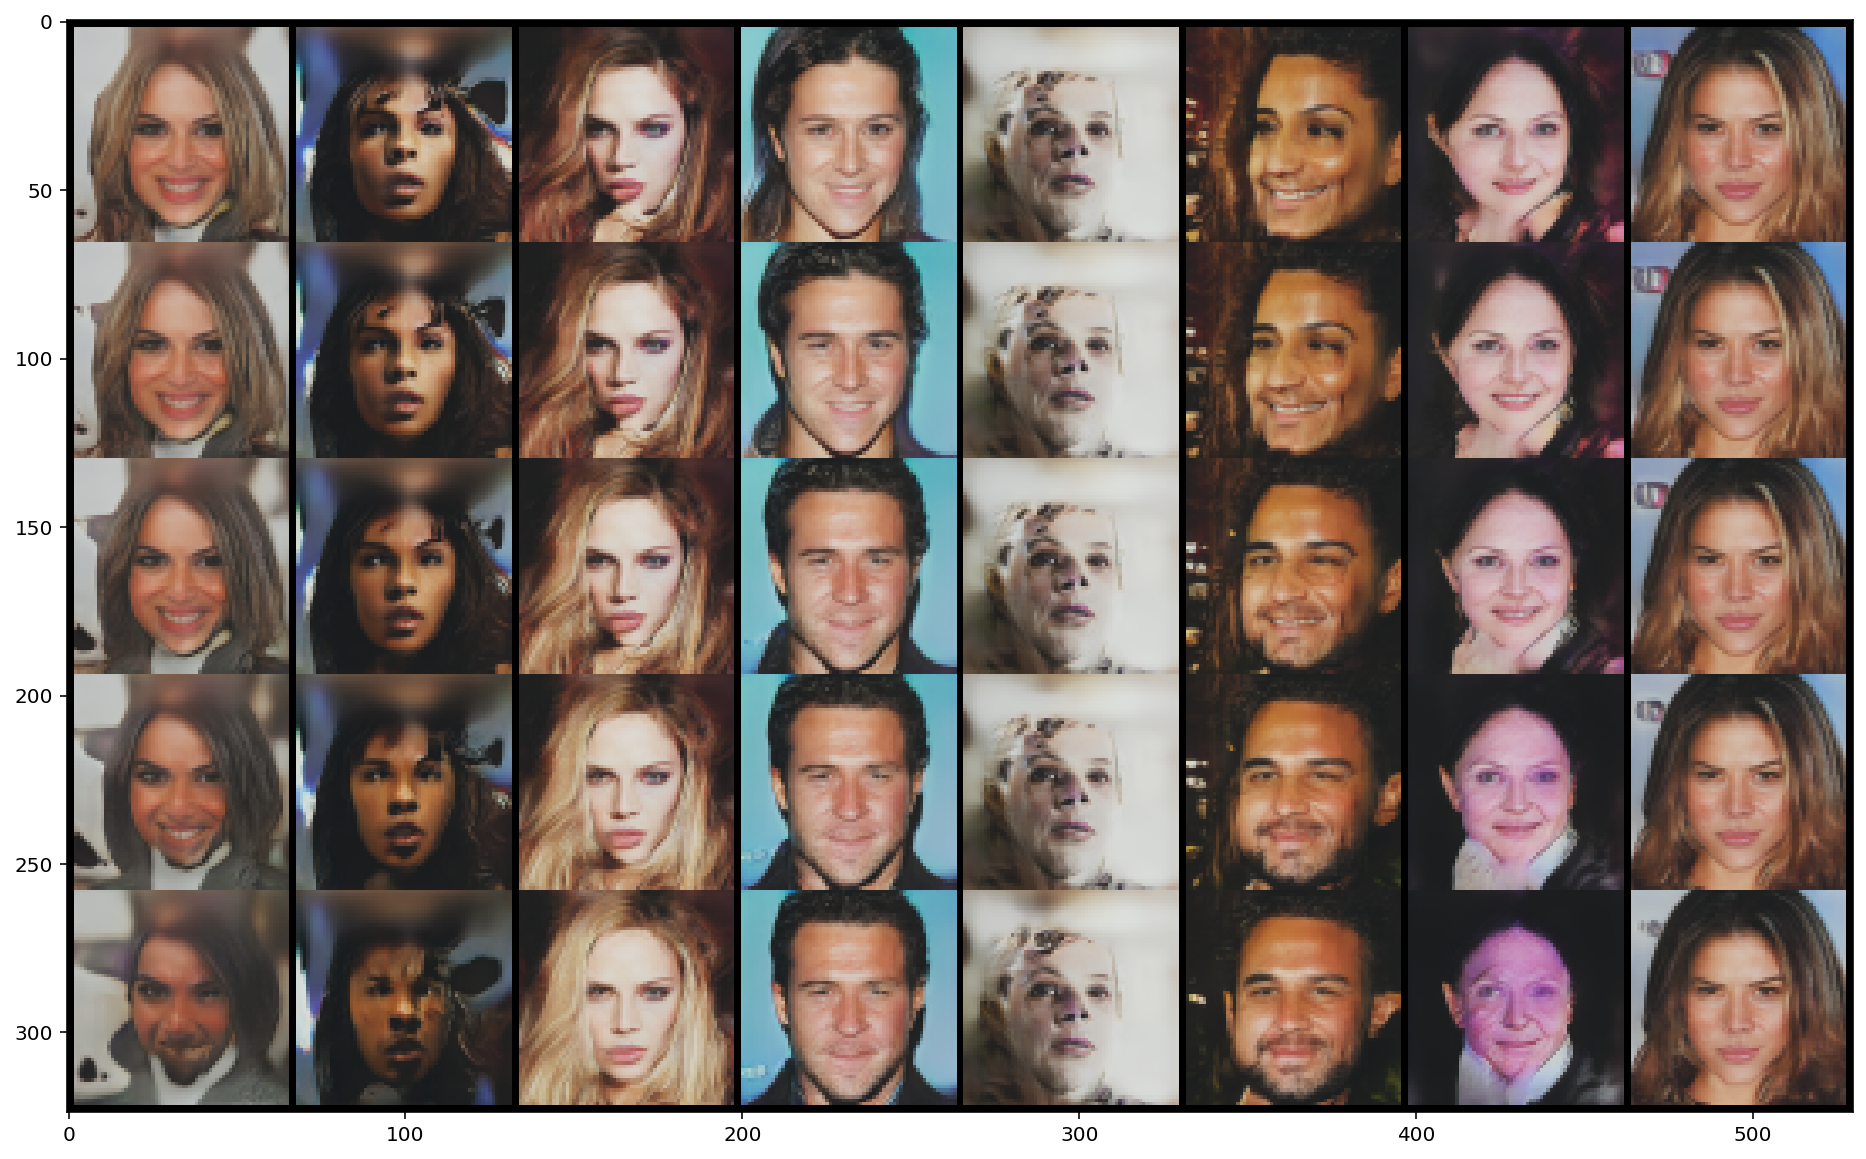

In [ ]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("Male") # Feel free to change this value to any string from feature_names!

# noise = get_noise(n_images, z_dim).to(device).requires_grad_()
noise, _ = model.buildNoiseData(n_images)
noise = noise.to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = F.interpolate(torch.tanh(gen(noise)), size=(64, 64), mode='area')
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)